In [1]:

'''First, we need to define the path of where to get the dataset, and define other parameters that we will need'''
import sys
sys.path.append('/Users/jakehirst/Desktop/sfx/sfx_ML_code/sfx_ML/New_Models')

from NN_fed_GPR import *
from NN_fed_RF import *
from RF_fed_GPR import *
from Bagging_models import *
from Backward_feature_selection import *
import ast

model_types = ['Single RF', 'Single GPR', 'NN_fed_GPR', 'NN_fed_RF', 'RF_fed_GPR']
model_types = ['NN_fed_RF', 'RF_fed_GPR']

# model_types = ['Single GPR']

all_labels = ['height', 'phi', 'theta', 
                            'impact site x', 'impact site y', 'impact site z', 
                            'impact site r', 'impact site phi', 'impact site theta']

labels_to_predict = ['impact site x', 'impact site y', 'height']
# labels_to_predict = ['height']

with_or_without_transformations = 'with'
with_or_without_transformations = 'without'

Paper2_path = f'/Volumes/Jake_ssd/Paper 2/{with_or_without_transformations}_transformations'
model_folder = Paper2_path + f'/UQ_bagging_models_{with_or_without_transformations}_transformations'
data_folder = Paper2_path + '/5fold_datasets'
results_folder = Paper2_path + '/Compare_Code_5_fold_ensemble_results'
hyperparam_folder = Paper2_path + f'/bayesian_optimization_{with_or_without_transformations}_transformations'

image_folder = '/Users/jakehirst/Desktop/sfx/sfx_ML_data/images_sfx/new_dataset/Visible_cracks'

if(with_or_without_transformations == 'with'):
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/dataset/feature_transformations_2023-11-16/height/HEIGHTALL_TRANSFORMED_FEATURES.csv"
    backward_feat_selection_results_folder = '/Volumes/Jake_ssd/Paper 1/Paper_1_results_WITH_feature_engineering/results'
else:
    full_dataset_pathname = "/Volumes/Jake_ssd/Paper 1/Paper_1_results_no_feature_engineering/dataset/New_Crack_Len_FULL_OG_dataframe_2023_11_16.csv"
    backward_feat_selection_results_folder = Paper2_path + '/Paper_2_results_WITHOUT_feature_engineering/results' 
    df = pd.read_csv(full_dataset_pathname, index_col=0)
    all_features = df.columns
    all_features = all_features.drop(all_labels)
    all_features = str(all_features.drop('timestep_init').to_list())

    print(all_features)
    
    
'''Only have to uncomment this if the 5 fold datasets have not been made or need to be remade'''
# make_5_fold_datasets(data_folder, full_dataset_pathname, image_folder)

print('ALL_TRANSFORMED_FEATURES' in full_dataset_pathname)

forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git
XGBoost is an optional dependency. If you want to use XGBoost models, please manually install xgboost package with pip install xgboost. If have error with finding libxgboost.dylib library, dobrew install libomp. If do not have brew on your system, first do ruby -e "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/master/install)" from the Terminal
scikit-lego is an optional dependency, enabling use of the LowessRegression model. If you want to use this model, do "pip install scikit-lego"
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'med

In [2]:
'''get the appropriate features that each model will use based on backward feature elimination'''
all_features_to_keep = {}

min_features = 1 #minimum number of features you want to select from BFS (backward feature selection)
max_features = 25 #maximum number of features you want to select from BFS
for label in labels_to_predict:
    all_features_to_keep[label] = {}
    for model_type in model_types:
        
        if('ALL_TRANSFORMED_FEATURES' in full_dataset_pathname):
            print('true')
            model_type_hyperparam = model_type.removeprefix('Single ')
            #TODO use code below if using feature selection
            best_features = get_best_features(backward_feat_selection_results_folder, label, model_type_hyperparam, min_features, max_features)
            all_features_to_keep[label][model_type] = best_features
        
        else:
            print('using just the basic features')
            #TODO use code below if NOT using feature selection
            all_features_to_keep[label][model_type] = all_features

print(all_features_to_keep)

using just the basic features
using just the basic features
using just the basic features
{'impact site x': {'RF_fed_GPR': "['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']"}, 'impact site y': {'RF_fed_GPR': "['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']"}, 'height': {'RF_fed_GPR': "['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crac

In [3]:
'''Now we will make all of the models'''


def make_UQ_model(training_features, training_labels, model_saving_folder, label_to_predict, num_models, features_to_keep, hyperparam_folder, num_training_points=False, model_type=None): 
    models = []
    training_features = training_features[features_to_keep]
    current_label = training_labels.columns[0]
    if(not os.path.exists(model_saving_folder)): os.mkdir(model_saving_folder)

    if(model_type == 'Single RF'):
        depth, features, samples_leaf, samples_split, estimators = get_best_hyperparameters_RF(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model =  RandomForestRegressor(max_depth=depth, max_features=features, 
                                       min_samples_leaf = samples_leaf, min_samples_split = samples_split, n_estimators=estimators, random_state=42)
        model.fit(training_features, training_labels)
        
    elif(model_type == 'Single GPR'):
        c, length_scale, noise_level = get_best_hyperparameters_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        kernel = ConstantKernel(constant_value=c) * RBF(length_scale=length_scale) + WhiteKernel(noise_level=noise_level)
        model = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=25)
        model.fit(training_features, training_labels)
        
    elif(model_type == 'NN_fed_GPR'):
        # c, length_scale, noise_level = get_best_hyperparameters_NN_fed_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model = NN_fed_GPR()
        model.fit(training_features, training_labels, hyperparam_folder)

    elif(model_type == 'RF_fed_GPR'):
        # c, length_scale, noise_level = get_best_hyperparameters_NN_fed_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model = RF_fed_GPR()
        model.fit(training_features, training_labels, hyperparam_folder)
        
    elif(model_type == 'NN_fed_RF'):
        # c, length_scale, noise_level = get_best_hyperparameters_NN_fed_GPR(label_to_predict=training_labels.columns[0], hyperparameter_folder=hyperparam_folder)
        model = NN_fed_RF()
        model.fit(training_features, training_labels, hyperparam_folder, num_optimization_tries=100, hyperparam_folder=f'/Volumes/Jake_ssd/Paper 2/without_transformations/optimized_hyperparams/NN_fed_RF/{current_label}')
        
    save_ensemble_model(model, 1, model_saving_folder) 
    
    return 



for fold_no in range(1,6):
    for model_type in model_types:
        for label_to_predict in labels_to_predict:
            print(f'\n$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting {label_to_predict} using {model_type} $$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n')
            
            all_labels = ['height', 'phi', 'theta', 
                        'impact site x', 'impact site y', 'impact site z', 
                        'impact site r', 'impact site phi', 'impact site theta']

            print(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv')
            training_features = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_features.csv').reset_index(drop=True)
            training_labels = pd.read_csv(f'{data_folder}/{label_to_predict}/fold{fold_no}/train_labels.csv').reset_index(drop=True)

            model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
            if(not os.path.exists(model_saving_folder)):
                os.makedirs(model_saving_folder)
                
            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
            if(not os.path.exists(results_saving_folder)):
                os.makedirs(results_saving_folder)
            # make_dirs(model_saving_folder)
            # make_dirs(results_saving_folder)

            '''TODO gotta find out what features to use for each label before testing on new dataset'''
            features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict][model_type])
            print(features_to_keep)
            make_UQ_model(training_features, training_labels, model_saving_folder, label_to_predict, 1, features_to_keep, hyperparam_folder, model_type=model_type)
            # make_linear_regression_models_for_ensemble(training_features, training_labels, model_saving_folder, label_to_predict, num_models, features_to_keep, hyperparam_folder, model_type=model_type)



$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting impact site x using RF_fed_GPR $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

/Volumes/Jake_ssd/Paper 2/without_transformations/5fold_datasets/impact site x/fold1/train_features.csv
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'linearity', 'max thickness', 'mean thickness', 'median_thickness', 'var_thickness', 'std_thickness', 'thickness_at_init', 'max_kink', 'abs_val_mean_kink', 'mean_kink', 'sum_kink', 'abs_val_sum_kink', 'median_kink', 'std_kink', 'var_kink', 'avg_ori', 'angle_btw']
OPTIMIZED GPR PARAMETERS FOR NN-->GPR = 21.3**2 * Matern(length_scale=100, nu=1.5) + WhiteKernel(noise_level=0.408)

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\ Predicting impact site y using RF_fed_GPR $$$$$$$$$$$$$$$$$$$$$$$$$$$$$

/Volumes/Jake_ssd/Paper 2/without_transformations/5fold_datasets/impact site y/fold1/train_features.csv
['init z', 'init y', 'init x', 'max_prop_speed', 'avg_prop_speed', 'dist btw frts', 'crack len', 'lineari

MODEL TYPE = RF_fed_GPR
LABEL = impact site x
fold 1
Calibration error = 1.77
fold 2
Calibration error = 0.37
fold 3
Calibration error = 1.27
fold 4
Calibration error = 0.93
fold 5
Calibration error = 1.66
LABEL = impact site y
fold 1
Calibration error = 0.42
fold 2
Calibration error = 0.92


ValueError: `bins` must be positive, when an integer

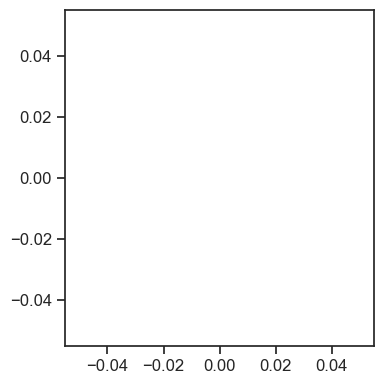

In [8]:

'''
Helper function predicts the labels of the featureset given, and the uncertainty.
Also compares this to the true labels of the dataset.
'''
def Get_predictions_and_uncertainty(test_features_path, test_labels_path, model_folder, saving_folder, features_to_keep, label_to_predict, model_type):
    if(not os.path.exists(saving_folder)): os.makedirs(saving_folder)
    test_features = pd.read_csv(test_features_path)[features_to_keep]
    test_labels = pd.read_csv(test_labels_path) 

    filename = model_folder + '/model_no1.sav'
    with open(os.path.join(model_folder, filename), 'rb') as file:
        model = pickle.load(file)
    
    # Loop through the pickle files in the folder
    # for filename in os.listdir(model_folder):
    #     if filename.endswith('.sav'):
    #         # Load the model from the pickle file
    #         with open(os.path.join(model_folder, filename), 'rb') as file:
    #             model = pickle.load(file)
    #             models.append(model)
    
    all_model_predictions = []
    # for model in models:
    if(model_type == 'Single RF'): 
        
        tree_predictions = []
        # Iterate over all trees in the random forest
        for tree in model.estimators_:
            # Predict using the current tree
            tree_pred = tree.predict(test_features.to_numpy())
            # Append the predictions to the list
            tree_predictions.append(tree_pred)

        # Convert the list to a NumPy array for easier manipulation if needed
        tree_predictions = np.array(tree_predictions)
        
        # current_predictions = model.predict(test_features.to_numpy()) #COMMENT this is the same as the average of all the individual trees
        current_predictions = np.mean(tree_predictions, axis=0)
        single_pred_stds = np.std(tree_predictions, axis=0)
        
    elif(model_type == 'Single GPR'):
        current_predictions, single_pred_stds = model.predict(test_features.to_numpy(), return_std=True)
        # current_predictions = model.predict(test_features.to_numpy())
            
        # current_predictions = model.predict(test_features.to_numpy())
        current_predictions = current_predictions.reshape(current_predictions.shape[0])
        all_model_predictions.append(current_predictions)
    
    elif(model_type == 'NN_fed_GPR'):
        current_predictions, single_pred_stds = model.predict(test_features.to_numpy())
        # current_predictions = model.predict(test_features.to_numpy())
            
        # current_predictions = model.predict(test_features.to_numpy())
        current_predictions = current_predictions.reshape(current_predictions.shape[0])
        all_model_predictions.append(current_predictions)
        
    elif(model_type == 'NN_fed_RF'):
        current_predictions, single_pred_stds = model.predict(test_features.to_numpy())
        # current_predictions = model.predict(test_features.to_numpy())
            
        # current_predictions = model.predict(test_features.to_numpy())
        current_predictions = current_predictions.reshape(current_predictions.shape[0])
        all_model_predictions.append(current_predictions)
    
    elif(model_type == 'RF_fed_GPR'):
        current_predictions, single_pred_stds = model.predict(test_features.to_numpy())
        # current_predictions = model.predict(test_features.to_numpy())
            
        # current_predictions = model.predict(test_features.to_numpy())
        current_predictions = current_predictions.reshape(current_predictions.shape[0])
        all_model_predictions.append(current_predictions)

    all_model_predictions = np.array(all_model_predictions)
    
    # ensemble_predictions = []
    # ensemble_uncertanties = []
    # for label_no in range(len(test_labels)):
    #     true_label = test_labels.iloc[label_no][0]
    #     mean_prediction, std_prediction = np.mean(all_model_predictions[:, label_no]), np.std(all_model_predictions[:, label_no])
    #     ensemble_predictions.append(mean_prediction)
    #     ensemble_uncertanties.append(std_prediction*2) #uncertainty will be 2 * the std of the predictions
    
    uncertainties = single_pred_stds * 2
    test_or_train = test_features_path.split('_')[-2].split('/')[-1]
    r2 = parody_plot_with_std(test_labels.to_numpy(), current_predictions, uncertainties, saving_folder, label_to_predict, model_type, testtrain=test_or_train)
    
    return r2, current_predictions, uncertainties, test_labels


'''Now we will evaluate the performance of the bagging models'''

for model_type in model_types:
    print(f'MODEL TYPE = {model_type}')
    for label_to_predict in labels_to_predict:
        print(f'LABEL = {label_to_predict}')
        performance_data = []
        for fold_no in range(1,6):
            print(f'fold {fold_no}')
            
            #defining folders to get the models and to store the results
            model_saving_folder = f'{model_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
            results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models/fold_{fold_no}'
            
            #defining folders where the datasets are coming from (5-fold cv)
            test_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_features.csv'
            test_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/test_labels.csv'
            train_features_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_features.csv'
            train_labels_path = Paper2_path + f'/5fold_datasets/{label_to_predict}/fold{fold_no}/train_labels.csv'

            #defining the features that each model used (since they vary with each model)
            features_to_keep = ast.literal_eval(all_features_to_keep[label_to_predict][model_type])
            
            #predicting the test and train sets with the bagging models
            test_r2, test_ensemble_predictions, test_ensemble_uncertanties, test_labels = Get_predictions_and_uncertainty(test_features_path, test_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)
            train_r2, train_ensemble_predictions, train_ensemble_uncertanties, train_labels = Get_predictions_and_uncertainty(train_features_path, train_labels_path, model_saving_folder, results_saving_folder, features_to_keep, label_to_predict, model_type)

            #defining the residual errors of the predictions
            train_labels_arr = train_labels.to_numpy().T[0]
            train_predictions_arr = np.array(train_ensemble_predictions)
            test_labels_arr = test_labels.to_numpy().T[0]
            test_predictions_arr = np.array(test_ensemble_predictions)
            train_residuals = pd.Series(np.abs(train_labels_arr - train_predictions_arr))
            test_residuals = pd.Series(np.abs(test_labels_arr - test_predictions_arr))

            a = 0
            b = 0
            '''getting calibration factors *** linear'''
            # cf = CorrectionFactors(train_residuals, pd.Series(train_ensemble_uncertanties))
            # a, b = cf.nll()
            # print(f'a = {a} b = {b}')
            # calibrated_train_uncertainties = pd.Series(a * np.array(train_ensemble_uncertanties) + b, name='train_model_errors')
            # calibrated_test_uncertainties = pd.Series(a * np.array(test_ensemble_uncertanties) + b, name='test_model_errors')
            
            '''getting calibration factors *** Nonlinear'''
            # a, b = get_calibration_factors(train_residuals, train_ensemble_uncertanties)
            # print(f'a = {a} b = {b}')
            # calibrated_train_uncertainties = pd.Series(a * (train_ensemble_uncertanties**((b/2) + 1)), name='train_model_errors')
            # calibrated_test_uncertainties = pd.Series(a * (test_ensemble_uncertanties**((b/2) + 1)), name='test_model_errors')

            '''
            Calculating and plotting performance metrics as outlined in section 2.3 of Tran et al. (https://dx.doi.org/10.1088/2632-2153/ab7e1a)
            
            Models should be compared in terms of 
            1st - accuracy (R^2) 
            2nd - calibration (miscalibration area)
            3rd - sharpness
            4th - dispersion
            '''
            #CALIBRATION plots and miscalibration area
            #This tells us how 'honest' our uncertainty values are. A perfect calibration plot would mean for a given confidence interval in our prediction
            #(say 90%), we can expect with 90% certainty that the true value falls within that confidence interval.
            miscalibration_area, calibration_error = make_calibration_plots(model_type, test_predictions_arr, test_labels_arr, test_ensemble_uncertanties, results_saving_folder)
            #SHARPNESS plots and value
            #Models can be calibrated, but all have very dull uncertainty values (they all have large uncertainties). To ensure UQ is meaningful, models
            #should a be sharp (i.e. uncertainties should be as small as possible.)
            #Sharpness is essentially calculated as the average of predicted standard deviations. #COMMENT Low sharpness values are better.
            stdevs = np.array(test_ensemble_uncertanties)/2 #right now, i multiply the stds by 2 to make it look better in parity plots... but this needs the raw std.
            sharpness, dispersion = plot_sharpness_curve(stdevs, results_saving_folder)
            #DISPERSION value
            #Models can be calibrated and sharp, but even so, if they are all similar uncertainties, then this does not tell us much. To ensure more 
            #meaningful UQ, having a large dispersion of uncertainties is valuable. 
            #Dispersion is calculated using equation 4 of the paper, which is called the coefficient of variation (Cv). #COMMENT High dispersion (Cv) values are better.
                
            
            # blank_model_for_plot = SklearnModel('RandomForestRegressor')
            # mastml_RVE = Error()

            # mastml_RVE.plot_real_vs_predicted_error_uncal_cal_overlay(savepath=results_saving_folder, 
            #                                                         model=blank_model_for_plot, 
            #                                                         data_type='train', 
            #                                                         model_errors=pd.Series(train_ensemble_uncertanties) ,
            #                                                         model_errors_cal= calibrated_train_uncertainties,
            #                                                         residuals= train_residuals, 
            #                                                         dataset_stdev=np.std(train_labels.to_numpy()), 
            #                                                         show_figure=False,
            #                                                         well_sampled_number=0.025)
            
            
            # mastml_RVE.plot_real_vs_predicted_error_uncal_cal_overlay(savepath=results_saving_folder, 
            #                                                         model=blank_model_for_plot, 
            #                                                         data_type='test', 
            #                                                         model_errors=pd.Series(test_ensemble_uncertanties) ,
            #                                                         model_errors_cal= calibrated_test_uncertainties,
            #                                                         residuals= test_residuals, 
            #                                                         dataset_stdev=np.std(train_labels.to_numpy()), 
            #                                                         show_figure=False,
            #                                                         well_sampled_number=0.025)
            
            '''using their library to make an rve plot'''
            # train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope = make_RVE_plots(label_to_predict, model_type, test_ensemble_predictions, test_ensemble_uncertanties, test_labels, train_ensemble_predictions, train_ensemble_uncertanties, train_labels, results_saving_folder, num_bins=15)
            
            '''collecting the performance data from this model'''
            # performance_data.append([15, fold_no, train_r2, test_r2, a, b, train_intercept, train_slope, CAL_train_intercept, CAL_train_slope, train_intercept, test_slope, CAL_test_intercept, CAL_test_slope, miscalibration_area, calibration_error])
            performance_data.append([fold_no, train_r2, test_r2, miscalibration_area, calibration_error, sharpness, dispersion])
            
        # columns = ['num bins', 'fold_no', 'train R2', 'test R2',  'a', 'b', 'train_intercept', 'train_slope', 'CAL_train_intercept', 'CAL_train_slope', 'train_intercept', 'test_slope', 'CAL_test_intercept', 'CAL_test_slope', 'miscal_area', 'cal_error']
        columns = ['fold_no', 'train R2', 'test R2', 'miscal_area', 'cal_error', 'sharpness', 'dispersion']
        df = pd.DataFrame(columns=columns)
        for row in performance_data:
            df.loc[len(df)] = row
        average_row = df.mean()
        df = df.append(average_row, ignore_index=True)
            
        results_saving_folder = f'{results_folder}/{label_to_predict}/{model_type}/1_models'
        df.to_csv(results_saving_folder + f'/{label_to_predict}_{model_type}_1results.csv', index=False)